# **Specific Test IV. Diffusion Models**
**Importing Libraries**
*   os: For handling file paths.
*   torch, torch.nn, torch.optim: PyTorch framework for building and training deep learning models.
*   torch.utils.data: Handles dataset management (loading and batching).
*   numpy: Used for numerical computations.
*   sklearn.model_selection.train_test_split: Splits data into training and testing sets.
*   ReduceLROnPlateau: A learning rate scheduler that reduces the learning rate if validation loss stops improving.
*   torch.nn.functional as F: Provides additional neural network functions (like activation functions).
*   json: Handles JSON file operations, possibly for storing model configurations or results.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import json

# **SSIMLoss function**

*  Inherits from nn.Module to create a custom loss function.

*  Takes window_size (default: 11) and size_average as parameters.

**Gaussian Window Function (gaussian_window)**

*  Creates a 2D Gaussian kernel to smooth images before computing SSIM.

*  Uses torch.exp(-(x - window_size // 2) ** 2 / (2 * sigma ** 2)) to generate the Gaussian distribution.

*  The kernel is expanded across image channels for batch processing.

**Forward Pass (forward)**

*  Computes mean intensity (mu1, mu2) of both images using convolution with a Gaussian kernel.

*  Computes variance (sigma1_sq, sigma2_sq) and covariance (sigma12).

Applies the SSIM formula

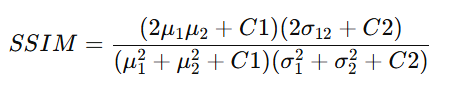
*  Returns 1 - SSIM to convert SSIM into a loss function.

In [ ]:
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def gaussian_window(self, channel, window_size, sigma=1.5):
        x = torch.arange(window_size, dtype=torch.float32)
        kernel = torch.exp(-(x - window_size // 2) ** 2 / (2 * sigma ** 2))
        kernel = kernel / kernel.sum()

        kernel_2d = kernel[:, None] * kernel[None, :]
        kernel_2d = kernel_2d.expand(channel, 1, window_size, window_size)
        return kernel_2d

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        window = self.gaussian_window(channel, self.window_size).to(img1.device)

        mu1 = F.conv2d(img1, window, padding=self.window_size//2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=self.window_size//2, groups=channel)

        mu1_sq, mu2_sq, mu1_mu2 = mu1.pow(2), mu2.pow(2), mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=self.window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=self.window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size//2, groups=channel) - mu1_mu2

        C1, C2 = 0.01**2, 0.03**2
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        return 1 - ssim.mean()

# **UNet architecture**

*  Inherits from nn.Module to define a custom neural network.
*  Implements an encoder-decoder architecture with a timestep embedding for time-dependent processing.

Architecture Components.,

**Timestep Embedding (self.time_embed)**
*  A small fully connected network that maps a single timestep input (t) to a 1024-dimensional vector.
*  Uses ReLU activation between two Linear layers.
*  The final embedding is reshaped to match the spatial dimensions of the encoder output.

**Encoder (self.encoder)**
*  A series of convolutional layers that progressively increase the number of channels (64 → 128 → 256 → 512 → 1024).
*  Uses Batch Normalization and ReLU activation after each convolution.

**Decoder (self.decoder)**

*  A series of convolutional layers that progressively reduce the number of channels (1024 → 512 → 256 → 128 → 64 → 32 → 1).

*  Uses Batch Normalization and ReLU activation, except for the last layer.

**Forward Pass (forward)**
1. Timestep Processing

*  The input timestep (t) is expanded, converted to float, and passed through self.time_embed.

*  The output is reshaped to (batch, 1024, 1, 1) to be added later to the encoder output.

2. Encoding

* The input image (x) passes through the encoder layers, extracting hierarchical features.

3. Adding Timestep Embedding

* The encoded feature map is added to the timestep embedding to condition the network on time.

4. Decoding

* The combined feature map is passed through the decoder layers to reconstruct the output.



In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Timestep embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
        )

        self.encoder = nn.ModuleList([
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        ])

        self.decoder = nn.ModuleList([
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        ])

    def forward(self, x, t):
        t = t.unsqueeze(-1).float()
        t_embed = self.time_embed(t)
        t_embed = t_embed.view(-1, 1024, 1, 1)

        for layer in self.encoder:
            x = layer(x)

        x = x + t_embed

        for layer in self.decoder:
            x = layer(x)

        return x

# **DDPM (Denoising Diffusion Probabilistic Model) Implementation**
**Class Definition (DDPM)**

*  Inherits from nn.Module to define a diffusion model.

*  Implements noise-based training and sampling for image generation.

**Main Components**
1. Constructor (__init__)

* Takes a model (e.g., U-Net) for noise prediction.

* Defines 1000 timesteps for diffusion by default.

*  Includes SSIMLoss and MSELoss for image similarity.

*  Uses lambda_mse and lambda_ssim to balance the two loss terms.

2. Loss Function (loss)

* Adds random noise to the input image (x).

* Uses the model to predict the added noise.

* Computes MSE loss (difference between predicted and true noise).

* Computes SSIM loss (structural similarity between denoised and original image).

* Returns a weighted sum of MSE loss and SSIM loss.

3. Forward Pass (forward): Calls the loss function to compute the loss for training.

**Sampling Process (sample)**
1. Initial Sampling

* Starts with a random noise tensor (x).

2. Reverse Diffusion (Loop over t)

* Iterates backwards from timestep 999 → 0.

* At each step:
> * Uses model to predict noise.
> * Computes denoised image estimate (x - predicted_noise).
> * Computes SSIM loss gradient and updates x.
> * Adds random noise proportional to the timestep (except at t=0).

**Final Output**

Returns the generated images after full denoising.



In [ ]:
class DDPM(nn.Module):
    def __init__(self, model, timesteps=1000, lambda_mse=0.5, lambda_ssim=0.5):
        super(DDPM, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.ssim_loss = SSIMLoss()
        self.mse_loss = nn.MSELoss()
        self.lambda_mse = lambda_mse
        self.lambda_ssim = lambda_ssim

    def loss(self, x, t):
        noise = torch.randn_like(x)
        noisy_x = x + noise
        predicted_noise = self.model(noisy_x, t)

        mse = self.mse_loss(predicted_noise, noise)
        ssim = self.ssim_loss(noisy_x - predicted_noise, x)
        total_loss = self.lambda_mse * mse + self.lambda_ssim * ssim
        return total_loss

    def forward(self, x, t):
        return self.loss(x, t)

    def sample(self, num_samples=1, image_size=(64, 64), device="cpu"):
        self.model.eval()
        with torch.no_grad():
            x = torch.randn((num_samples, 1, *image_size), device=device)

            for t in range(self.timesteps - 1, -1, -1):
                t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.float32)
                predicted_noise = self.model(x, t_tensor)
                estimated_clean = x - predicted_noise
                ssim_loss = self.ssim_loss(estimated_clean, x)
                ssim_grad = torch.autograd.grad(ssim_loss.sum(), x)[0]
                x = x - predicted_noise - self.lambda_ssim * ssim_grad

                if t > 0:
                    noise = torch.randn_like(x)
                    x = x + noise * (1.0 - (t/self.timesteps))

        return x


# **LensingDataset Implementation**
**Class Definition (LensingDataset)**

*  Inherits from torch.utils.data.Dataset to create a custom dataset for gravitational lensing images.

**Main Components**
1. Constructor (__init__): Takes a list of file_paths pointing to .npy files containing image data.

2. Dataset Length (__len__): Returns the total number of files in file_paths.

3. Data Loading (__getitem__):

* Loads .npy image data using np.load().

* Converts it to a PyTorch tensor (torch.from_numpy(data).float()).

* Ensures single-channel format by adding a dimension if needed (data.unsqueeze(0)).

* Resizes the image to (64, 64) using bilinear interpolation.

* Normalizes the image by subtracting the mean and dividing by the standard deviation ((data - mean) / (std + 1e-8)).

* Returns the processed image tensor.

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        data = torch.from_numpy(data).float()
        if len(data.shape) == 2:
            data = data.unsqueeze(0)
        data = torch.nn.functional.interpolate(data.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
        mean = data.mean()
        std = data.std()
        data = (data - mean) / (std + 1e-8)
        return data

# **Model Training**
**Function Definition (train)**

* Trains a diffusion model using a dataset loaded via train_loader.

* Uses Adam optimizer and ReduceLROnPlateau scheduler for adaptive learning rate adjustment.


**Device Selection**: Uses GPU if available, otherwise defaults to CPU.

**Model Setup**

*  Moves the model to the selected device.

*  Initializes Adam optimizer with a learning rate (lr=5e-5).

*  Uses ReduceLROnPlateau to reduce learning rate if training loss plateaus.

**Training Loop (epochs iterations)**

* Sets model to training mode (model.train()).

* Initializes training loss for tracking.

* Iterates over mini-batches from train_loader:

> * Moves the batch to the correct device.
> * Resets gradients (optimizer.zero_grad()).
> * Samples a random timestep t (between 0 and model.timesteps).
> * Computes loss by passing batch and t to the model.
> * Performs backpropagation (loss.backward()).
> * Updates model parameters (optimizer.step()).
> * Accumulates training loss.

**Loss Calculation & Scheduler Update**

* Computes average loss per epoch and prints it.

* Adjusts the learning rate using scheduler.step(train_loss).

In [ ]:
def train(model, train_loader, epochs=25, lr=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            t = torch.randint(0, model.timesteps, (batch.shape[0],), dtype=torch.float32, device=device)
            loss = model(batch, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {round(train_loss, 4)}")
        scheduler.step(train_loss)



1. Trains a DDPM (Denoising Diffusion Probabilistic Model) on a subset of the Lensing dataset.

2. Saves trained model weights in JSON format for later use.

3. Dataset Preparation

> * Loads .npy image files from Samples/Samples/.
> * Splits dataset into train (90%) and validation (10%) using train_test_split().
> * Selects a random 0.5% subset of training data to speed up training.
> * Creates a DataLoader with batch size = 32 and shuffling enabled.

4. Model Initialization: Creates a DDPM model with a UNet backbone and 500 diffusion timesteps.

5. Model Training

> * Calls the train() function, training the model for 25 epochs.
>*Training loss steadily decreases, indicating learning progress.
>*Final loss drops from 1.0042 to 0.6779, showing effective training.

6. Saving Model Weights

>* Moves model to CPU before saving.
>* Extracts model state dictionary (weights).
>*Converts tensors into JSON-serializable format (lists, shapes, and data types).
>* Saves weights to "ddpm_model_weights.json".

**Training Observations**
1. Smooth Loss Reduction: Loss decreases gradually from 1.0042 → 0.6779 over 25 epochs, showing effective model optimization.

2. Future Improvements
>* Increase training subset size for better generalization.
>*Longer training (more epochs) may further enhance performance.
>*Use validation loss monitoring to detect overfitting.

In [ ]:
def main():
    data_dir = 'Samples/Samples'
    file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
    train_paths, val_paths = train_test_split(file_paths, test_size=0.1, random_state=42)
    subset_size = int(0.05 * len(train_paths))
    train_paths = np.random.choice(train_paths, subset_size, replace=False).tolist()
    train_loader = DataLoader(LensingDataset(train_paths), batch_size=32, shuffle=True)
    model = DDPM(UNet(), timesteps=500)
    train(model, train_loader)
   

# Ensure model is in CPU mode for serialization
    model = model.cpu()

# Get the state dictionary (model weights)
    state_dict = model.state_dict()

# Convert tensors to lists for JSON serialization
    state_dict_json = {
    key: {
        'data': value.cpu().numpy().tolist(),  # Convert to list
        'shape': list(value.shape),           # Preserve original shape
        'dtype': str(value.dtype)             # Preserve data type
    }
    for key, value in state_dict.items()
}

# Save to a JSON file
    with open("ddpm_model_weights.json", "w") as json_file:
     json.dump(state_dict_json, json_file, indent=4)

    print("Model weights saved to ddpm_model_weights.json")

if __name__ == '__main__':
    main()

Epoch 1/25, Train Loss: 1.0042
Epoch 2/25, Train Loss: 0.9711
Epoch 3/25, Train Loss: 0.9547
Epoch 4/25, Train Loss: 0.9415
Epoch 5/25, Train Loss: 0.9401
Epoch 6/25, Train Loss: 0.931
Epoch 7/25, Train Loss: 0.9311
Epoch 8/25, Train Loss: 0.9244
Epoch 9/25, Train Loss: 0.9231
Epoch 10/25, Train Loss: 0.911
Epoch 11/25, Train Loss: 0.9049
Epoch 12/25, Train Loss: 0.8813
Epoch 13/25, Train Loss: 0.8728
Epoch 14/25, Train Loss: 0.8671
Epoch 15/25, Train Loss: 0.8537
Epoch 16/25, Train Loss: 0.8451
Epoch 17/25, Train Loss: 0.8364
Epoch 18/25, Train Loss: 0.7955
Epoch 19/25, Train Loss: 0.7792
Epoch 20/25, Train Loss: 0.7753
Epoch 21/25, Train Loss: 0.7527
Epoch 22/25, Train Loss: 0.7355
Epoch 23/25, Train Loss: 0.7057
Epoch 24/25, Train Loss: 0.7118
Epoch 25/25, Train Loss: 0.6779
Model weights saved to ddpm_model_weights.json
